# Vortex sheet behind elliptically loaded wing

In [1]:
using Pkg
Pkg.activate("/Users/beckers/Google Drive/Academic/UCLA/CodingInProgress/ViscousFlow.jl");
using ViscousFlow
using Plots
using LinearAlgebra
using DifferentialEquations
using BenchmarkTools
using PotentialFlow
# pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [2]:
tf = 0.2

0.2

In [3]:
function streamfunctionSnapshot(u::VectorData,vortices_Γ)
    w = Nodes(Dual,(nx,ny));
    L⁻¹(w::T) where {T} = L\w;
    
    Hw = Regularize(u,dx;ddftype=Fields.M4prime,issymmetric=true)
    Hw(w,vortices_Γ)
    
    # Solve for streamfunction
    ψ = -(L\(w));
    return ψ
    
    # Calculate velocity field
#     q .= curl(ψ)/(dx); 
end 

streamfunctionSnapshot (generic function with 1 method)

## PotentialFlow.jl

In [4]:
N = 200
α = range(0, π, length = 2N+1)
zs = complex.(cos.(α)).+(2.0+2.0im)
Γs = sin.(α)
δ = 0.05;
Δt = 0.001;

In [5]:
function compute_ẋ!(ẋ, x, t)
    reset_velocity!(ẋ, x)
    self_induce_velocity!(ẋ, x, t)
end

compute_ẋ! (generic function with 1 method)

In [6]:
sheet = Vortex.Sheet(zs, Γs, δ)
original_sheet = deepcopy(sheet)
w = allocate_velocity(sheet);
for t in 0.0:Δt:tf
    forward_euler!(sheet, sheet, t, Δt, compute_ẋ!, advect!, w)
end

In [7]:
sheet.blobs

401-element Array{PotentialFlow.Blobs.Blob{Float64},1}:
 Vortex.Blob(2.917526085909224 + 2.0498285825315103im, 0.003926950444355667, 0.05)   
 Vortex.Blob(2.91755420868999 + 2.049822000420959im, 0.007853658655910338, 0.05)     
 Vortex.Blob(2.9176384613034676 + 2.049802705737039im, 0.007852931972449408, 0.05)   
 Vortex.Blob(2.9177784916921428 + 2.0497720423825982im, 0.007851720883153808, 0.05)  
 Vortex.Blob(2.9179736974822394 + 2.0497322134928835im, 0.00785002546272923, 0.05)   
 Vortex.Blob(2.9182232047240064 + 2.049686226748723im, 0.007847845815757183, 0.05)   
 Vortex.Blob(2.9185258423222944 + 2.049637818634218im, 0.007845182076688568, 0.05)   
 Vortex.Blob(2.918880116071168 + 2.0495913586366443im, 0.007842034409835358, 0.05)   
 Vortex.Blob(2.9192841869238206 + 2.0495517348848638im, 0.007838403009360471, 0.05)  
 Vortex.Blob(2.9197358585526123 + 2.049524223312997im, 0.007834288099265785, 0.05)   
 Vortex.Blob(2.920232579331679 + 2.049514343076795im, 0.00782968993337834, 0.05)    

## ViscousFlow.jl

In [8]:
mutable struct PointVortex
    x::Real
    y::Real
    Γ::Real
end

### Eulerian grid

In [9]:
nx = 128; ny = 128;
Lx = 4.0;
dx = Lx/(nx-2);
display(dx)
s = Nodes(Dual,(nx,ny));
q = Edges(Primal,(nx,ny));
ψ = Nodes(Dual,s);
L = plan_laplacian(size(s),with_inverse=true)
L⁻¹(s::T) where {T} = L\s;

0.031746031746031744

### Problem parameters

In [10]:
nvortices = 400
xmin_sheet = 1.0
xmax_sheet = 3.0
y_sheet = 2.0
Γ(x) = -(1-(x-2.0)^2)^0.5
dΓdx(x) = (x-2.0)*(1-(x-2.0)^2)^(-0.5)
tloc = 0.0

0.0

### Vortex sheet

In [11]:
α = range(0, π, length = nvortices)


vortices = Array{PointVortex,1}()
x_sheet = cos.(α).+2.0
Γ_sheet = sin.(α)
σ_sheet = dΓdx.(x_sheet)


# for i in 1:nvortices
#     push!(vortices,PointVortex(x_sheet[i],y_sheet,σ_sheet[i]))
# end

# First vortex
vortex = PointVortex(x_sheet[1],y_sheet,0.5*(Γ_sheet[2]-Γ_sheet[1]))
push!(vortices,vortex)
# Middle vortices
for i in 2:nvortices-1
    vortex = PointVortex(x_sheet[i],y_sheet,0.5*(Γ_sheet[i+1]-Γ_sheet[i-1]))
    push!(vortices,vortex)
end
# Last vortex
vortex = PointVortex(x_sheet[nvortices],y_sheet,0.5*(Γ_sheet[nvortices]-Γ_sheet[nvortices-1]))
push!(vortices,vortex);

In [12]:
x_sheet

400-element Array{Float64,1}:
 3.0               
 2.9999690028535855
 2.9998760133359883
 2.9997210372120273
 2.9995040840893386
 2.9992251674177766
 2.998884304488584 
 2.998481516433316 
 2.998016828222535 
 2.9974902686642557
 2.9969018704021675
 2.9962516699136037
 2.995539707507284 
 ⋮                 
 1.0037483300863965
 1.0030981295978325
 1.0025097313357443
 1.0019831717774654
 1.001518483566684 
 1.0011156955114162
 1.0007748325822234
 1.0004959159106614
 1.0002789627879727
 1.0001239866640117
 1.0000309971464145
 1.0               

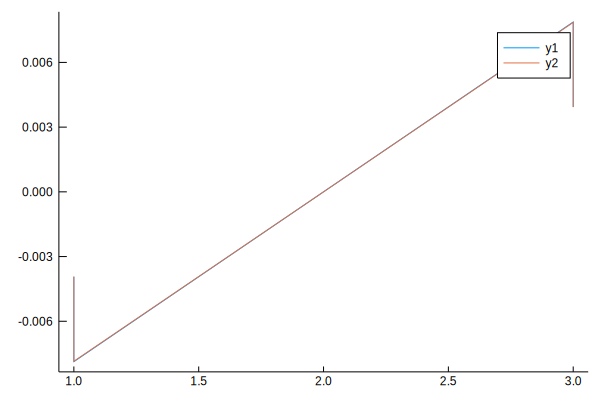

In [13]:
plot(x_sheet,[vortex.Γ for vortex in vortices])
plot!(real((v->v.z).(original_sheet.blobs)),(v->v.S).(original_sheet.blobs))
# plot!(1.0:0.0001:3.0,dΓdx.(1.0:0.0001:3.0))
# plot!(xlims=(0.9,3.1),ylims=(-2.5,2.5))

# plot(x_sheet,-Γ.(x_sheet))
# plot!(real((v->v.z).(sheet₊.blobs)),(sheet₊.Ss))

In [14]:
function rhs(vel::VectorData,vortices_loc::VectorData,params::Tuple{Nodes,Edges,ScalarData},t)
    
    # Regularize vorticity to grid
    Hw = Regularize(vortices_loc,dx;ddftype=Fields.M4prime,issymmetric=true)
    Hw(s,vortices_Γ)
    
    # Solve for streamfunction
    s .= -(L\(s)); 
    
    # Calculate velocity field
    q .= curl(s)/(dx);
        
    # Interpolate to nodes before interpolating to vortex point
    Fields.interpolate!((s),q.u);
    Hw(vel.u,s)
    Fields.interpolate!((s),q.v);
    Hw(vel.v,s)

    return vel
        
end 

rhs (generic function with 1 method)

### Time marching

In [15]:
# tf = 0.1
tspan = (0.0,tf);
vortices_loc = VectorData([vortex.x for vortex in vortices],[vortex.y for vortex in vortices])
vortices_Γ = ScalarData([vortex.Γ for vortex in vortices])
# u0 = [vortices_loc.u vortices_loc.v]
prob = ODEProblem(rhs,vortices_loc,tspan,(s,q,vortices_Γ))

ODEProblem with uType VectorData{400} and tType Float64. In-place: true
timespan: (0.0, 0.2)
u0: [3.0, 2.99997, 2.99988, 2.99972, 2.9995, 2.99923, 2.99888, 2.99848, 2.99802, 2.99749  …  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]

In [16]:
sol = solve(prob,RK4(),dense=false);

### Plot results

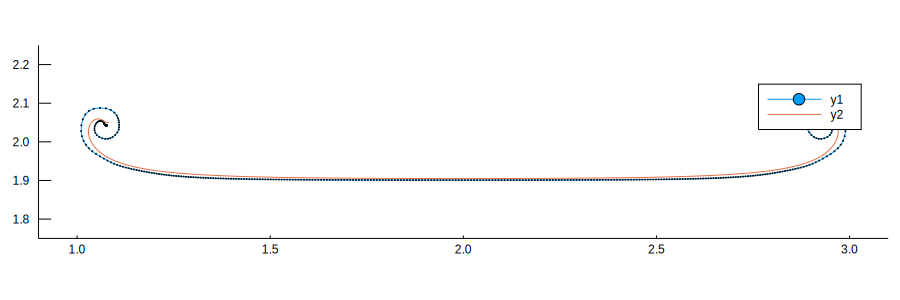

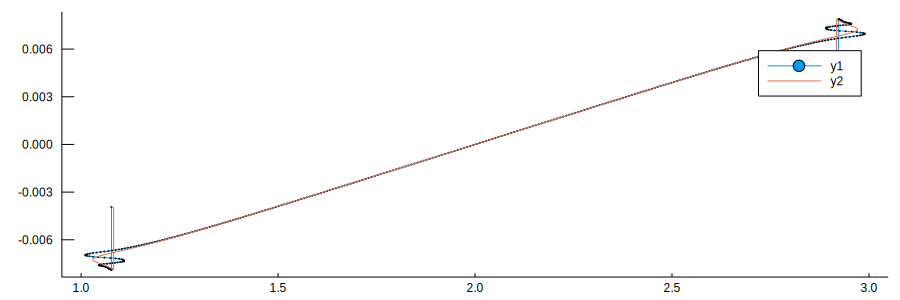

In [17]:
xg,yg = coordinates(ψ,dx=dx)
coord = [(x,y) for x in xg, y in yg]

matched_tuples = [(i,i+nvortices) for i in 1:nvortices]

#==============================PLOT VORTEX SHEET POSITION================================#

p4 = #plot(xg,yg,s,levels=20);
plot(xlims=(0.9,3.1),ylims=(1.75,2.25))
#ViscousFlow
plot!(sol[end].u,sol[end].v,markershape=:circle,markersize=0.3,ratio=1,size=[900,300])
#PotentialFlow
plot!(real((v->v.z).(sheet.blobs)),imag((v->v.z).(sheet.blobs)))

#==============================PLOT VORTEX SHEET STRENGTH================================#

#ViscousFlow
p5 = plot(sol[end].u,vortices_Γ,markershape=:circle,markersize=0.3,size=[900,300])
#PotentialFlow
plot!(real((v->v.z).(sheet.blobs)),(v->v.S).(sheet.blobs))


display(p4)
display(p5)


In [18]:
# paired_indices = nvortices
# plots_array = Array{Plots.Plot,1}()

# for i in 1:nvortices
#     p = scatter(first.(coord)[:],last.(coord)[:],ratio=:equal,markersize=1)
#     plot!(sol,vars=(i,i+nvortices),lw=2)
#     scatter!([sol[end][i]],[sol[end][i+nvortices]])
#     xlims!(minimum(sol[i,:])-1*dx,maximum(sol[i,:])+1*dx)
#     ylims!(minimum(sol[i+nvortices,:])-1*dx,maximum(sol[i+nvortices,:])+1*dx)
#     push!(plots_array,p)
# end

# p3 = plot(plots_array...,layout=(1,nvortices),size=[800,400])
# savefig("vortex_pair_rotating_goza_trajectories.pdf")

# display(p3)

In [19]:
ψ_array = typeof(s)[]
tstamps = range(0,stop=tf,length=100)
for i in 1:length(tstamps)
    vortices_location = VectorData(sol(tstamps[i])[1:nvortices],sol(tstamps[i])[nvortices+1:2*nvortices])
    push!(ψ_array,streamfunctionSnapshot(vortices_location,vortices_Γ))
end

In [20]:
contourlevels = range(-0.47,stop=0.47,length=20)

-0.47:0.049473684210526316:0.47

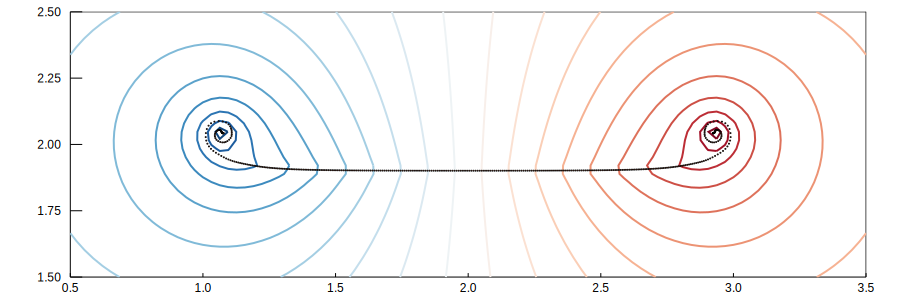

In [21]:
i=100
plot(xg,yg,-ψ_array[i],levels=contourlevels,c=:RdBu,linewidth=2,xlims=(0.5,Lx-0.5),ylims=(1.5,2.5),legend=false,size=[900,300])
scatter!(sol(tstamps[i])[1:nvortices],sol(tstamps[i])[nvortices+1:2*nvortices],markershape=:circle,markersize=0.3,ratio=1)


In [22]:
anim = @animate for i=1:length(tstamps)
    plot(xg,yg,-ψ_array[i],levels=contourlevels,c=:RdBu,linewidth=2,xlims=(0.5,Lx-0.5),ylims=(1.5,2.5),legend=false,size=[900,300])
    scatter!(sol(tstamps[i])[1:nvortices],sol(tstamps[i])[nvortices+1:2*nvortices],markercolor=:black,markersize=1,ratio=1)
end
gif(anim, "vortex_roll_up_fps15.gif", fps = 15)

┌ Info: Saved animation to 
│   fn = /Users/beckers/Google Drive/Academic/UCLA/CodingInProgress/ViscousFlow.jl/notebooks/vortex_roll_up_fps15.gif
└ @ Plots /Users/beckers/.julia/packages/Plots/l0VjU/src/animation.jl:90


Plots.AnimatedGif("/Users/beckers/Google Drive/Academic/UCLA/CodingInProgress/ViscousFlow.jl/notebooks/vortex_roll_up_fps15.gif")

### Analytical results

In [108]:
d = sqrt((vortices[1].x-vortices[2].x)^2 + (vortices[1].y-vortices[2].y)^2)

0.5

#### Opposite circulation

In [109]:
U = vortices[1].Γ/(4π*d)
println("Analytical self-induced velocity = $U")
println("Analytical distance traveled = $(U*tf)")
println("Numerical distance traveled = $(sol[1][1]-sol[end][1])")

Analytical self-induced velocity = 0.15915494309189535
Analytical distance traveled = 0.784633869443044
Numerical distance traveled = 0.002885700269819935


#### Equal circulation

In [111]:
T = 2π^2*d^2/vortices[1].Γ
println("Analytical period = $T")

Analytical period = 4.934802200544679


In [70]:
0.050550532375431945/1.5915494309189535

0.031761836229142

In [71]:
dx*2

0.031746031746031744

In [248]:
function lorenz(testdu,u,p,t)
 testdu[1] = 10.0*(u[2]-u[1])
 testdu[2] = u[1]*(28.0-u[3]) - u[2]
 testdu[3] = u[1]*u[2] - (8/3)*u[3]
end

lorenz (generic function with 1 method)

In [249]:
u0 = [1.0;0.0;0.0]
tspan = (0.0,1.0)
prob = ODEProblem(lorenz,u0,tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 1.0)
u0: [1.0, 0.0, 0.0]

In [250]:
sol = solve(prob)

retcode: Success
Interpolation: Automatic order switching interpolation
t: 28-element Array{Float64,1}:
 0.0                  
 3.5678604836301404e-5
 0.0003924646531993154
 0.0032624016752212923
 0.00905808176456279  
 0.0169564955927642   
 0.02769000245764448  
 0.04185634375662893  
 0.06024025665362463  
 0.0836852441654334   
 0.11336451506889586  
 0.14862131186030308  
 0.18703929175446188  
 ⋮                    
 0.3722098913969515   
 0.42013571940411776  
 0.46371861478076454  
 0.5049442389863666   
 0.5570599548490927   
 0.6068364009391921   
 0.6690177692283815   
 0.7276616574784435   
 0.7988511236820154   
 0.8763173594796152   
 0.9661595671190406   
 1.0                  
u: 28-element Array{Array{Float64,1},1}:
 [1.0, 0.0, 0.0]                    
 [0.999643, 0.000998805, 1.78143e-8]
 [0.996105, 0.0109654, 2.14696e-6]  
 [0.969359, 0.0897704, 0.000143801] 
 [0.924204, 0.242289, 0.00104616]   
 [0.880045, 0.438737, 0.00342427]   
 [0.848331, 0.691564, 0.00848765]  